**Table of Contents** <br>
* [1.Imports](#imports)
* [2.Loading the datasets](#loaddata)
* [3. Data exploration](#explor)
* [4. Data preparation](#dataprep)
* [5. Preprocessing](#preprocessing)
* [6. Model training](#train)
* [7. Model assessment](#assess)
* [8. Prediction](#prediction)

<hr>
<a class="anchor" id="imports">
    
# 1. Imports
    
</a>

In [116]:
import pandas as pd
import numpy as np
import datetime
from math import ceil

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.feature_selection import mutual_info_classif, f_classif, chi2, RFECV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn import metrics
from kds import metrics as kds_metrics

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", 100)

import warnings
warnings.filterwarnings("ignore")

<hr>
<a class="anchor" id="loaddate">
    
# 2. Loading the data
    
</a>

In [3]:
#dataframe to store the results of the models
model_metrics = pd.DataFrame(columns=['Precision','Recall','F1 Score', 'AUC'])

# importing datasets
df = pd.read_csv('data/train.csv')

df.set_index('Access_ID', inplace=True)

# from object to date
df.Date = df.Date.apply(lambda x: datetime.datetime.strptime(x, "%d-%b-%y"))

In [4]:
# data partition
X = df.drop('Buy', axis=1)
y = df['Buy']

# spliting data in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [5]:
print(X_train.shape)
print(X_test.shape)

(7499, 15)
(2500, 15)


In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7499 entries, 750621161 to 210337741
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        7499 non-null   datetime64[ns]
 1   AccountMng_Pages            7499 non-null   int64         
 2   AccountMng_Duration         7499 non-null   float64       
 3   FAQ_Pages                   7499 non-null   int64         
 4   FAQ_Duration                7499 non-null   float64       
 5   Product_Pages               7499 non-null   int64         
 6   Product_Duration            7499 non-null   float64       
 7   GoogleAnalytics_BounceRate  7499 non-null   float64       
 8   GoogleAnalytics_ExitRate    7499 non-null   float64       
 9   GoogleAnalytics_PageValue   7499 non-null   float64       
 10  OS                          7499 non-null   object        
 11  Browser                     7499 non-null  

<hr>
<a class="anchor" id="explor">
    
# 3. Data exploration
    
</a>

In [7]:
# list of categorical features
class_features = ['OS','Browser','Type_of_Visitor','Type_of_Traffic','Country']

# list of numerical features
metric_features = list(X_train.columns[~X_train.columns.isin(class_features)])
metric_features.remove('Date')

In [8]:
print(class_features)
print(metric_features)

['OS', 'Browser', 'Type_of_Visitor', 'Type_of_Traffic', 'Country']
['AccountMng_Pages', 'AccountMng_Duration', 'FAQ_Pages', 'FAQ_Duration', 'Product_Pages', 'Product_Duration', 'GoogleAnalytics_BounceRate', 'GoogleAnalytics_ExitRate', 'GoogleAnalytics_PageValue']


In [18]:
def plot_num_features(df, features):
    
    """ This function was created to analyse the distribution of numerical features by
    plotting a boxplot and a histogram for each feature in features.
    
    Arguments:
    
    - df: dataframe with the features
    - features: string with feature name or list of feature names to plot
    
    """
    
    for feat in features:

        f, axs = plt.subplots(2,2,figsize=(15,5))
        plt.subplot(1, 2, 1)
        sns.boxplot(x=df[feat])
        plt.title('Boxplot', fontsize = 15)


        plt.subplot(1, 2, 2)
        sns.histplot(pd.concat([X_train,y_train],axis=1), x=feat, multiple="layer", hue='Buy')
        plt.title('Histogram', fontsize = 15)

        plt.xlabel(feat)
        plt.show()

In [29]:
def plot_class_feat(df,features):
    
    """ This function was created to analyse the distribution of categorical features by
    plotting a barplot of the size of each level and the conversion rate.
    
    Arguments:
    
    - df: dataframe with the features
    - features: string with feature name or list of feature names to plot
    
    """
    
    for feat in features:
    
        dist = pd.Series(df[feat].value_counts(normalize=False), name='Distribution')
        prop = pd.Series(df.groupby(feat).Buy.agg('mean'), name='Conversion')
        dt = pd.concat([dist,prop], axis=1)

        fig = plt.figure() # Create matplotlib figure
        
        ax = fig.add_subplot(111) # Create matplotlib axes
        ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
        dt['Distribution'].plot(kind='bar', color='tab:blue', ax=ax, width=0.4, position=1)
        dt['Conversion'].plot(kind='bar', color='tab:orange', ax=ax2, width=0.4, position=0)

        ax.set_ylabel('# rows')
        ax2.set_ylabel('Conversion (%)')
        plt.title(feat)
        plt.show()

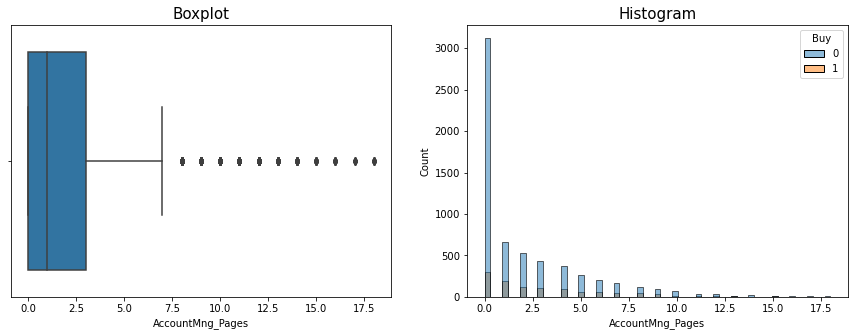

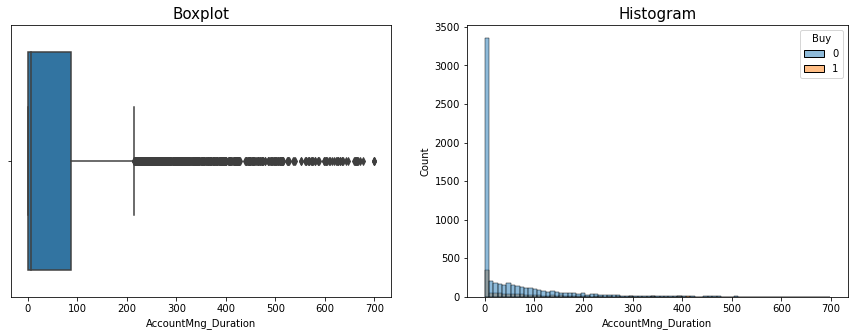

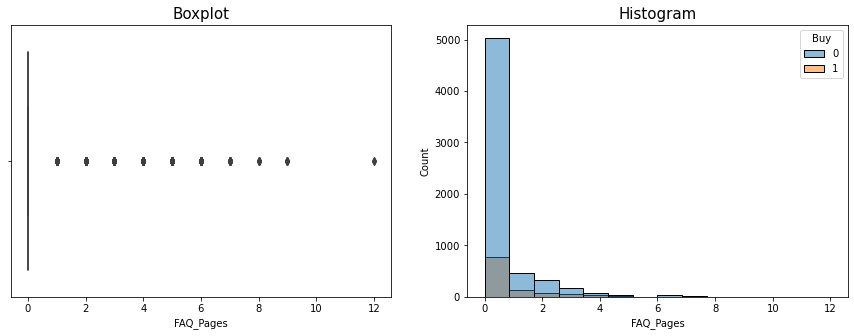

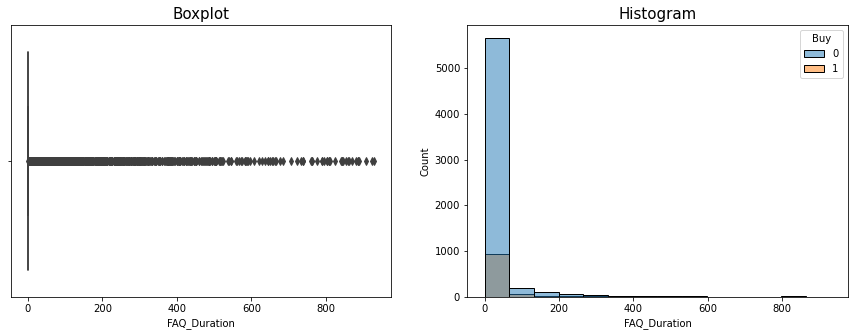

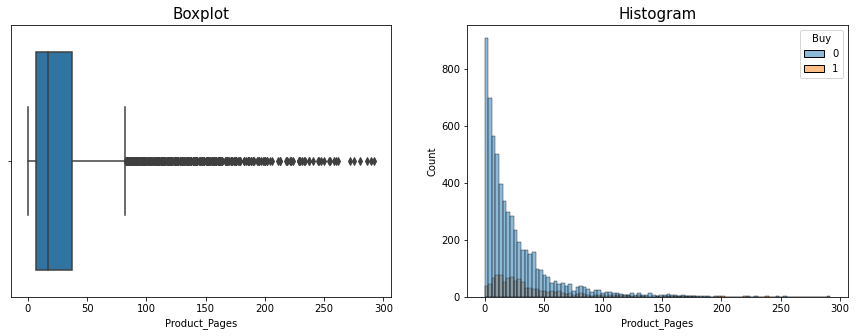

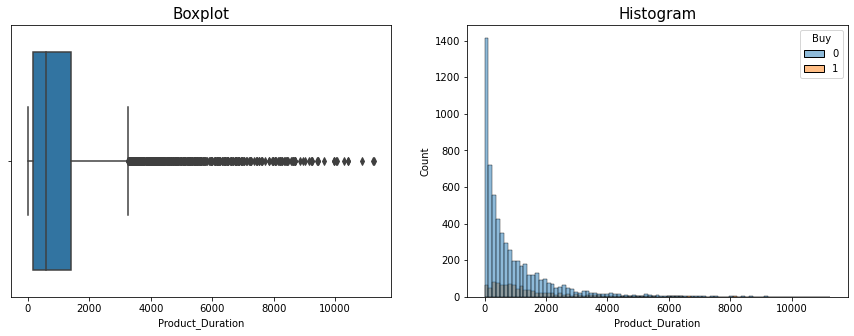

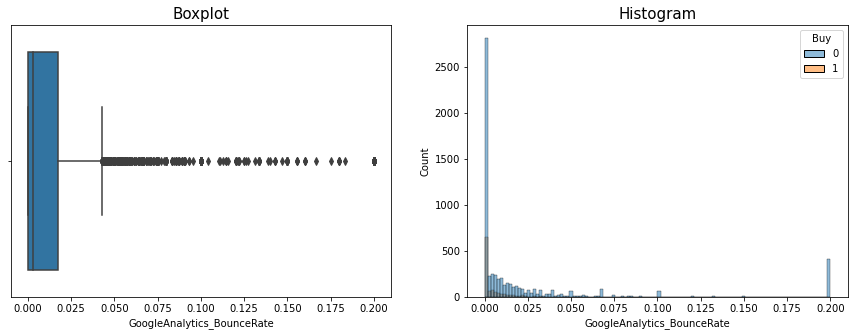

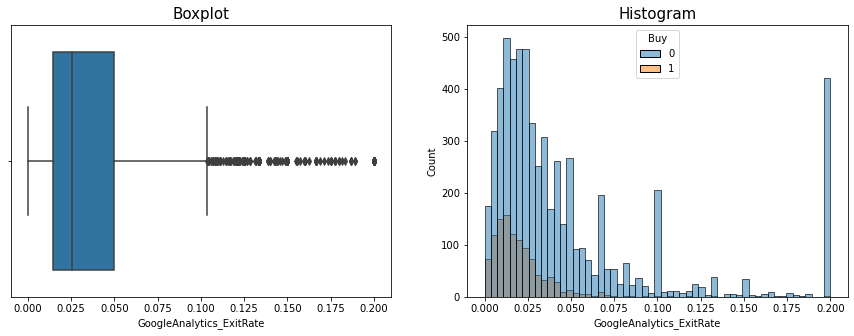

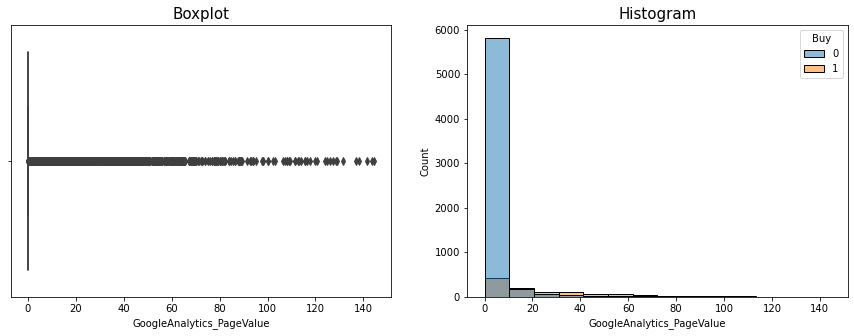

In [30]:
plot_num_features(X_train, metric_features)

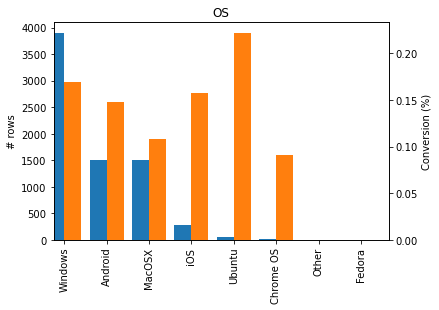

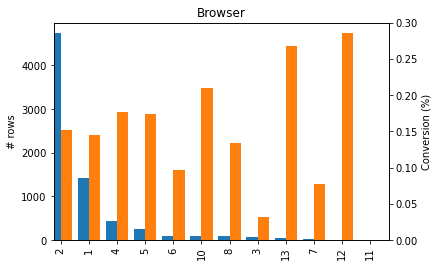

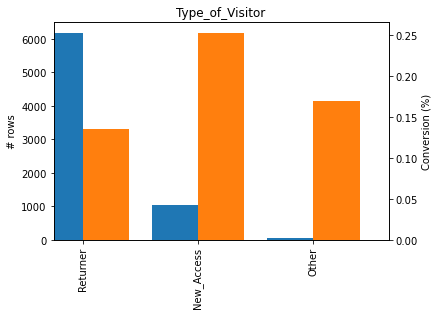

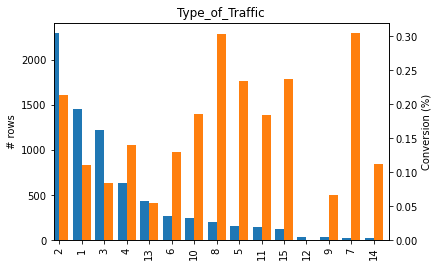

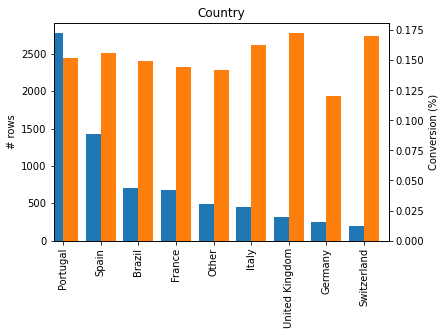

In [31]:
plot_class_feat(pd.concat([X_train,y_train],axis=1), class_features)

<hr>
<a class="anchor" id="dataprep">
    
# 4. Data preparation
    
</a>

In [21]:
# there is duplicated data?
X_train.duplicated().sum()

9

In [22]:
# remove duplicates
X_train.drop_duplicates(keep='first', inplace=True)

In [23]:
## removing outliers based on the data exploration
X_train = X_train.loc[
    (X_train['AccountMng_Pages']<= 20)
    &
    (X_train['AccountMng_Duration']<=700)
    &
    (X_train['FAQ_Pages']<= 12)
    &
    (X_train['FAQ_Duration']<= 1000)
    &
    (X_train['Product_Pages'] <= 300)
    &
    (X_train['Product_Duration'] <= 12000)
     &
    (X_train['GoogleAnalytics_PageValue'] <= 150)
    &
    (X_train['GoogleAnalytics_ExitRate'] <= 0.2)
    &
    (X_train['GoogleAnalytics_BounceRate'] <= 0.2)
]

In [24]:
print('We kept {:.1f}% of the original data'.format((len(X_train)/(7499)*100)))

We kept 97.0% of the original data


In [25]:
# remove outliers from y
y_train = y_train[X_train.index]

In [26]:
# consistency check
X_train.describe()

,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Browser,Type_of_Traffic
count,7276.000000,7276.000000,7276.000000,7276.000000,7276.000000,7276.000000,7276.000000,7276.000000,7276.000000,7276.000000,7276.000000
mean,2.179219,63.137830,0.449835,25.424799,29.166575,1077.199427,0.022100,0.043328,5.467816,2.350055,3.958906
std,3.066106,106.718133,1.128128,91.784251,35.236891,1409.629410,0.048429,0.048584,15.567122,1.706805,3.676744
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,174.233325,0.000000,0.014300,0.000000,2.000000,2.000000
50%,1.000000,6.000000,0.000000,0.000000,17.000000,581.250000,0.002900,0.025600,0.000000,2.000000,2.000000
75%,3.000000,86.000000,0.000000,0.000000,37.000000,1407.979175,0.017100,0.050000,0.000000,2.000000,4.000000
max,18.000000,699.166700,12.000000,929.000000,292.000000,11257.108300,0.200000,0.200000,144.393500,13.000000,15.000000


<hr>
<a class="anchor" id="preprocessing">
    
# 5. Preprocessing
    
</a>

### 5.1) Feature engineering

In [32]:
# get details from the date
X_train['Month_Access'] = X_train.Date.apply(lambda x: x.month)
X_train['WDay_Access'] = X_train.Date.apply(lambda x: x.weekday()) ## monday is 0
X_train['Day_Access'] = X_train.Date.apply(lambda x: x.day)

In [33]:
## drop Date
X_train.drop('Date', axis=1, inplace=True)

In [34]:
## encoding categorical

dummy_os = pd.get_dummies(X_train['OS'], prefix='OS')
dummy_browser = pd.get_dummies(X_train['Browser'], prefix='Browser')
dummy_country = pd.get_dummies(X_train['Country'], prefix='Country')
dummy_traffic = pd.get_dummies(X_train['Type_of_Traffic'], prefix='Traffic')
dummy_visitor = pd.get_dummies(X_train['Type_of_Visitor'], prefix='Visitor')
dummy_day = pd.get_dummies(X_train['Day_Access'], prefix='Day')
dummy_wkday = pd.get_dummies(X_train['WDay_Access'], prefix='WDay')
dummy_month = pd.get_dummies(X_train['Month_Access'], prefix='Month')

## merge dummy variables
X_encoded = pd.concat([X_train,dummy_browser,dummy_country,dummy_traffic,dummy_visitor,dummy_day,dummy_wkday,dummy_month], axis=1)

## drop original ones
X_encoded.drop(class_features+['Day_Access','WDay_Access','Month_Access'], axis=1, inplace=True)

In [35]:
# calculate new variables

# # total number of pages visited and total durantion of visits
X_encoded['Total_Pages'] = X_encoded['AccountMng_Pages']+X_encoded['FAQ_Pages']+X_encoded['Product_Pages']
X_encoded['Total_Duration'] = X_encoded['AccountMng_Duration']+X_encoded['FAQ_Duration']+X_encoded['Product_Duration']

# # # proportion of visits by each pages and duration
X_encoded['Prop_AccountMng_Pages'] = X_encoded['AccountMng_Pages']/X_encoded['Total_Pages']
X_encoded['Prop_FAQ_Pages'] = X_encoded['FAQ_Pages']/X_encoded['Total_Pages']
X_encoded['Prop_Product_Pages'] = X_encoded['Product_Pages']/X_encoded['Total_Pages']

X_encoded['Prop_AccountMng_Duration'] = X_encoded['AccountMng_Duration']/X_encoded['Total_Duration']
X_encoded['Prop_FAQ_Duration'] = X_encoded['FAQ_Duration']/X_encoded['Total_Duration']
X_encoded['Prop_Product_Duration'] = X_encoded['Product_Duration']/X_encoded['Total_Duration']

# # # averages times spent in each page
X_encoded['Avg_AccountMng_Duration'] = X_encoded['AccountMng_Duration']/X_encoded['AccountMng_Pages']
X_encoded['Avg_FAQ_Duration'] = X_encoded['FAQ_Duration']/X_encoded['FAQ_Pages']
X_encoded['Avg_Product_Duration'] = X_encoded['Product_Duration']/X_encoded['Product_Pages']

# total average
X_encoded['Avg_Duration'] = X_encoded['Total_Duration']/X_encoded['Total_Pages']

# got some nans because of the division by 0
X_encoded.fillna(0, inplace=True)

In [36]:
## preparing test dataset

# get details from the date
X_test['Month_Access'] = X_test.Date.apply(lambda x: x.month)
X_test['WDay_Access'] = X_test.Date.apply(lambda x: x.weekday()) ## monday is 0
X_test['Day_Access'] = X_test.Date.apply(lambda x: x.day)

X_test.drop('Date', axis=1, inplace=True)

## encoding categorical

dummy_os = pd.get_dummies(X_test['OS'], prefix='OS')
dummy_browser = pd.get_dummies(X_test['Browser'], prefix='Browser')
dummy_country = pd.get_dummies(X_test['Country'], prefix='Country')
dummy_traffic = pd.get_dummies(X_test['Type_of_Traffic'], prefix='Traffic')
dummy_visitor = pd.get_dummies(X_test['Type_of_Visitor'], prefix='Visitor')
dummy_day = pd.get_dummies(X_test['Day_Access'], prefix='Day')
dummy_wkday = pd.get_dummies(X_test['WDay_Access'], prefix='WDay')
dummy_month = pd.get_dummies(X_test['Month_Access'], prefix='Month')

## merge dummy variables
X_test = pd.concat([X_test,dummy_browser,dummy_country,dummy_traffic,dummy_visitor,dummy_day,dummy_wkday,dummy_month], axis=1)

## drop original ones
X_test.drop(class_features+['Day_Access','WDay_Access','Month_Access'], axis=1, inplace=True)

In [37]:
# calculate new variables

# # total number of pages visited and total durantion of visits
X_test['Total_Pages'] = X_test['AccountMng_Pages']+X_test['FAQ_Pages']+X_test['Product_Pages']
X_test['Total_Duration'] = X_test['AccountMng_Duration']+X_test['FAQ_Duration']+X_test['Product_Duration']

# # # proportion of visits by each pages and duration
X_test['Prop_AccountMng_Pages'] = X_test['AccountMng_Pages']/X_test['Total_Pages']
X_test['Prop_FAQ_Pages'] = X_test['FAQ_Pages']/X_test['Total_Pages']
X_test['Prop_Product_Pages'] = X_test['Product_Pages']/X_test['Total_Pages']

X_test['Prop_AccountMng_Duration'] = X_test['AccountMng_Duration']/X_test['Total_Duration']
X_test['Prop_FAQ_Duration'] = X_test['FAQ_Duration']/X_test['Total_Duration']
X_test['Prop_Product_Duration'] = X_test['Product_Duration']/X_test['Total_Duration']

# # # averages times spent in each page
X_test['Avg_AccountMng_Duration'] = X_test['AccountMng_Duration']/X_test['AccountMng_Pages']
X_test['Avg_FAQ_Duration'] = X_test['FAQ_Duration']/X_test['FAQ_Pages']
X_test['Avg_Product_Duration'] = X_test['Product_Duration']/X_test['Product_Pages']

# total average
X_test['Avg_Duration'] = X_test['Total_Duration']/X_test['Total_Pages']

# got some nans because of the division by 0
X_test.fillna(0, inplace=True)

### 5.2) Feature standardization    

In [38]:
X_encoded.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7276 entries, 750621161 to 210337741
Data columns (total 108 columns):
 #    Column                      Dtype  
---   ------                      -----  
 0    AccountMng_Pages            int64  
 1    AccountMng_Duration         float64
 2    FAQ_Pages                   int64  
 3    FAQ_Duration                float64
 4    Product_Pages               int64  
 5    Product_Duration            float64
 6    GoogleAnalytics_BounceRate  float64
 7    GoogleAnalytics_ExitRate    float64
 8    GoogleAnalytics_PageValue   float64
 9    Browser_1                   uint8  
 10   Browser_2                   uint8  
 11   Browser_3                   uint8  
 12   Browser_4                   uint8  
 13   Browser_5                   uint8  
 14   Browser_6                   uint8  
 15   Browser_7                   uint8  
 16   Browser_8                   uint8  
 17   Browser_10                  uint8  
 18   Browser_11                  uint8

In [39]:
metric_features = metric_features+list(X_encoded.columns[96:])

In [40]:
metric_features

['AccountMng_Pages',
 'AccountMng_Duration',
 'FAQ_Pages',
 'FAQ_Duration',
 'Product_Pages',
 'Product_Duration',
 'GoogleAnalytics_BounceRate',
 'GoogleAnalytics_ExitRate',
 'GoogleAnalytics_PageValue',
 'Total_Pages',
 'Total_Duration',
 'Prop_AccountMng_Pages',
 'Prop_FAQ_Pages',
 'Prop_Product_Pages',
 'Prop_AccountMng_Duration',
 'Prop_FAQ_Duration',
 'Prop_Product_Duration',
 'Avg_AccountMng_Duration',
 'Avg_FAQ_Duration',
 'Avg_Product_Duration',
 'Avg_Duration']

In [41]:
X_scaled = X_encoded.copy()
X_test_scaled = X_test.copy()

# fit scaler
scaler = StandardScaler().fit(X_encoded[metric_features])

# transfrom dataframes
X_scaled[metric_features] = scaler.transform(X_encoded[metric_features])
X_test_scaled[metric_features] = scaler.transform(X_test[metric_features])

In [42]:
X_scaled.head()

,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Browser_1,Browser_2,Browser_3,Browser_4,Browser_5,Browser_6,Browser_7,Browser_8,Browser_10,Browser_11,Browser_12,Browser_13,Country_Brazil,Country_France,Country_Germany,Country_Italy,Country_Other,Country_Portugal,Country_Spain,Country_Switzerland,Country_United Kingdom,Traffic_1,Traffic_2,Traffic_3,Traffic_4,Traffic_5,Traffic_6,Traffic_7,Traffic_8,Traffic_9,Traffic_10,Traffic_11,Traffic_12,Traffic_13,Traffic_14,Traffic_15,Visitor_New_Access,Visitor_Other,Visitor_Returner,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31,WDay_0,WDay_1,WDay_2,WDay_3,WDay_4,WDay_5,WDay_6,Month_2,Month_3,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Total_Pages,Total_Duration,Prop_AccountMng_Pages,Prop_FAQ_Pages,Prop_Product_Pages,Prop_AccountMng_Duration,Prop_FAQ_Duration,Prop_Product_Duration,Avg_AccountMng_Duration,Avg_FAQ_Duration,Avg_Product_Duration,Avg_Duration
Access_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
750621161,-0.710794,-0.591672,-0.398772,-0.277025,-0.629116,-0.508289,-0.456378,-0.206424,-0.351265,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,-0.669985,-0.546754,-0.621228,-0.275192,0.655214,-0.518406,-0.25355,0.572021,-0.521454,-0.245812,0.304198,0.320665
604299187,-0.710794,-0.591672,-0.398772,-0.277025,-0.430447,-0.537022,-0.456378,-0.618109,3.000458,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,-0.480843,-0.574261,-0.621228,-0.275192,0.655214,-0.518406,-0.25355,0.572021,-0.521454,-0.245812,-0.319118,-0.327091
715276670,0.593882,0.119284,-0.398772,-0.277025,1.215668,0.529017,-0.315956,-0.381390,0.377795,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.194414,0.497825,-0.213407,-0.275192,0.291912,-0.246731,-0.25355,0.422946,0.050521,-0.245812,-0.265996,-0.279441
492745692,-0.710794,-0.591672,-0.398772,-0.277025,-0.487210,-0.565898,-0.456378,-0.500779,-0.351265,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,-0.534883,-0.601906,-0.621228,-0.275192,0.655214,-0.518406,-0.25355,0.572021,-0.521454,-0.245812,-0.309970,-0.317584
121280698,-0.710794,-0.591672,-0.398772,-0.277025,-0.316922,-0.124296,-0.456378,-0.739556,-0.351265,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-0.372762,-0.179144,-0.621228,-0.275192,0.655214,-0.518406,-0.25355,0.572021,-0.521454,-0.245812,0.273215,0.288468


### 5.3) Reduction of input space

In [62]:
#Now we are checking the correlation between the variables
def correlation(df, threshold, features):   
    #To obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
    corre = round(df[features].corr(),2)

    #To build annotation matrix (values above |threshold| will appear annotated in the plot)
    mask_annot = np.absolute(corre.values) >= threshold
    annot = np.where(mask_annot, corre.values, np.full(corre.shape,""))
    
    mask = np.triu(np.ones_like(corre, dtype=bool))
    
    
    #To prepare figure
    fig = plt.figure(figsize=(12, 10))

    # Plot heatmap of the correlation matrix
    sns.heatmap(data=corre, annot=annot, mask = mask,cmap=sns.diverging_palette(220, 10, as_cmap=True), 
                fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

    # Layout
    fig.subplots_adjust(top=0.95)
    fig.suptitle("Correlation Matrix", fontsize=20)

    plt.show()

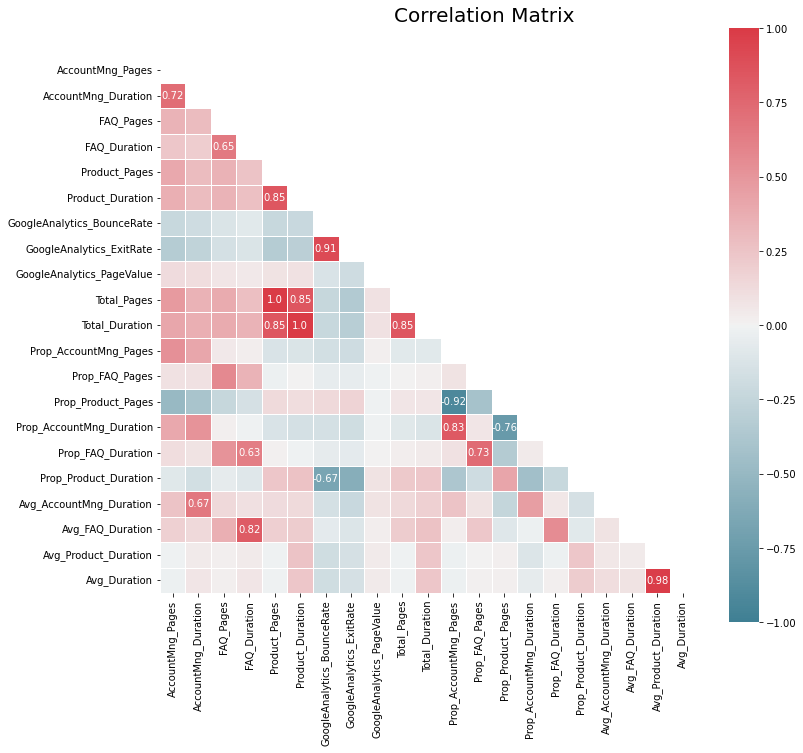

In [28]:
correlation(X_scaled,0.6, metric_features)

In [43]:
# remove features with more than 90% correlation
X_scaled.drop(columns=['Total_Pages','Prop_AccountMng_Pages','Avg_Product_Duration','GoogleAnalytics_BounceRate'], inplace=True)

In [44]:
metric_features.remove('Total_Pages')
metric_features.remove('Prop_AccountMng_Pages')
metric_features.remove('Avg_Product_Duration')
metric_features.remove('GoogleAnalytics_BounceRate')

<hr>
<a class="anchor" id="featureselect">
    
# 6. Feature selection
    
</a> 

In [45]:
mutual_score = pd.Series(mutual_info_classif(X_scaled[metric_features], y_train, n_neighbors=50, random_state=42), name='mutual_info', index=metric_features)

In [46]:
mutual_score.sort_values(ascending=False)

GoogleAnalytics_PageValue    0.163747
GoogleAnalytics_ExitRate     0.040967
Total_Duration               0.027685
Product_Duration             0.026397
Avg_Duration                 0.024801
Product_Pages                0.020341
Prop_Product_Duration        0.019728
Prop_Product_Pages           0.016962
Avg_AccountMng_Duration      0.014748
Prop_AccountMng_Duration     0.014153
AccountMng_Duration          0.013935
AccountMng_Pages             0.013834
FAQ_Pages                    0.004612
Prop_FAQ_Pages               0.004593
FAQ_Duration                 0.004565
Avg_FAQ_Duration             0.003662
Prop_FAQ_Duration            0.002989
Name: mutual_info, dtype: float64

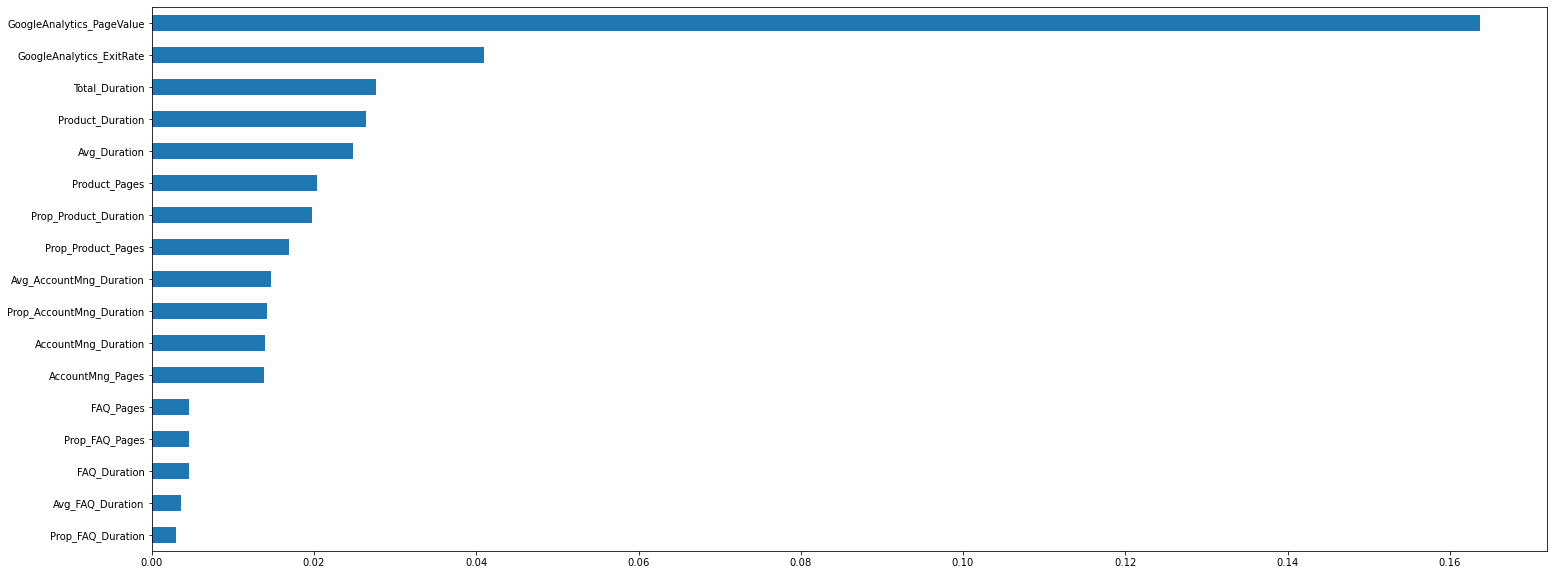

In [47]:
fig = plt.figure(figsize=(25,10))
mutual_score.sort_values().plot(kind='barh')
plt.show()

In [48]:
mi_selected = set(list(mutual_score[mutual_score>0.01].index))

In [49]:
f_score = pd.Series(f_classif(X_scaled[metric_features], y_train)[0], name='f_test', index=metric_features)

In [50]:
f_score.sort_values(ascending=False)

GoogleAnalytics_PageValue    3037.487044
GoogleAnalytics_ExitRate      321.237839
Total_Duration                217.522569
Product_Duration              201.419962
Product_Pages                 181.310010
AccountMng_Pages              131.886905
AccountMng_Duration            99.874426
Avg_AccountMng_Duration        57.788155
FAQ_Pages                      53.794565
FAQ_Duration                   43.755600
Prop_Product_Duration          31.373301
Prop_Product_Pages             22.126146
Avg_FAQ_Duration               21.749375
Prop_AccountMng_Duration        9.958079
Avg_Duration                    7.355401
Prop_FAQ_Duration               3.243077
Prop_FAQ_Pages                  0.459279
Name: f_test, dtype: float64

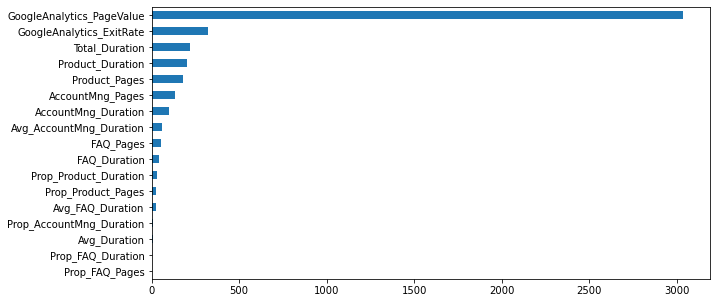

In [51]:
fig = plt.figure(figsize=(10,5))
f_score.sort_values().plot(kind='barh')
plt.show()

In [52]:
f_selected = set(list(f_score[f_score>=20].index))

In [53]:
f_selected

{'AccountMng_Duration',
 'AccountMng_Pages',
 'Avg_AccountMng_Duration',
 'Avg_FAQ_Duration',
 'FAQ_Duration',
 'FAQ_Pages',
 'GoogleAnalytics_ExitRate',
 'GoogleAnalytics_PageValue',
 'Product_Duration',
 'Product_Pages',
 'Prop_Product_Duration',
 'Prop_Product_Pages',
 'Total_Duration'}

In [54]:
chi_score = pd.Series(chi2(X_scaled[X_scaled.columns[~X_scaled.columns.isin(metric_features)]], y_train)[0], name='chi_2', index=X_scaled.columns[~X_scaled.columns.isin(metric_features)])

In [55]:
# top 20 features
chi_score.sort_values(ascending=False)[0:20]

Month_11              107.940566
Visitor_New_Access     82.145746
Traffic_2              65.619720
Traffic_3              43.722650
Month_3                36.241801
Traffic_8              34.291345
Month_5                32.611057
Traffic_13             31.799720
Traffic_1              19.609746
Month_2                17.787257
Visitor_Returner       13.946980
Month_10               13.658949
Traffic_5               8.276282
Browser_3               6.897269
Traffic_15              6.657898
WDay_2                  6.078566
Traffic_12              5.736143
Day_7                   4.647077
Browser_13              4.301149
Traffic_7               4.141025
Name: chi_2, dtype: float64

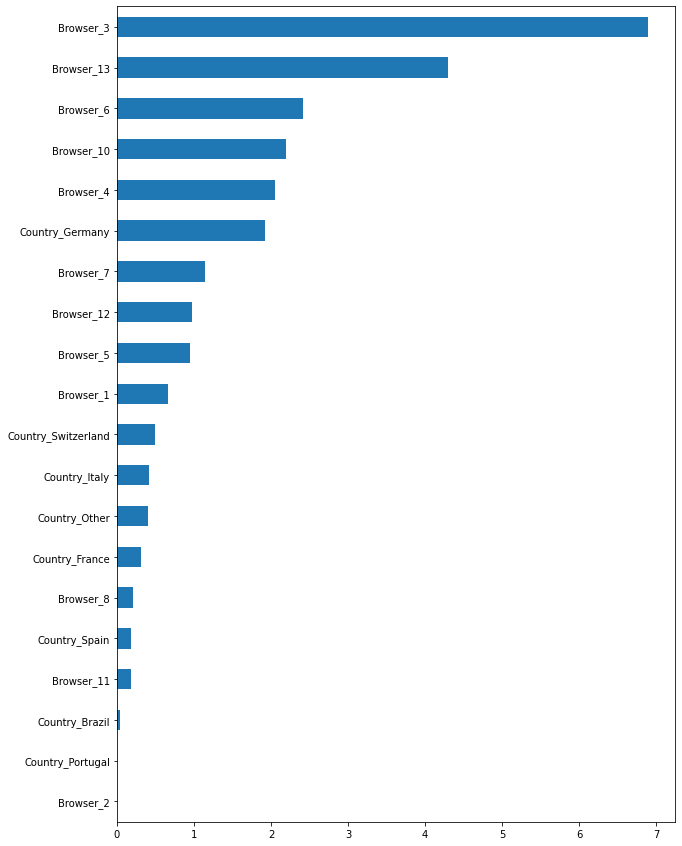

In [56]:
fig = plt.figure(figsize=(10,15))
chi_score[0:20].sort_values().plot(kind='barh')
plt.show()

In [57]:
chi_selected = set(list(chi_score[chi_score>=10].index))

In [58]:
selected_features = mi_selected.union(f_selected,chi_selected)

In [59]:
selected_features

{'AccountMng_Duration',
 'AccountMng_Pages',
 'Avg_AccountMng_Duration',
 'Avg_Duration',
 'Avg_FAQ_Duration',
 'FAQ_Duration',
 'FAQ_Pages',
 'GoogleAnalytics_ExitRate',
 'GoogleAnalytics_PageValue',
 'Month_10',
 'Month_11',
 'Month_2',
 'Month_3',
 'Month_5',
 'Product_Duration',
 'Product_Pages',
 'Prop_AccountMng_Duration',
 'Prop_Product_Duration',
 'Prop_Product_Pages',
 'Total_Duration',
 'Traffic_1',
 'Traffic_13',
 'Traffic_2',
 'Traffic_3',
 'Traffic_8',
 'Visitor_New_Access',
 'Visitor_Returner'}

In [60]:
X_selected = X_scaled.copy()
X_selected = X_selected[selected_features]

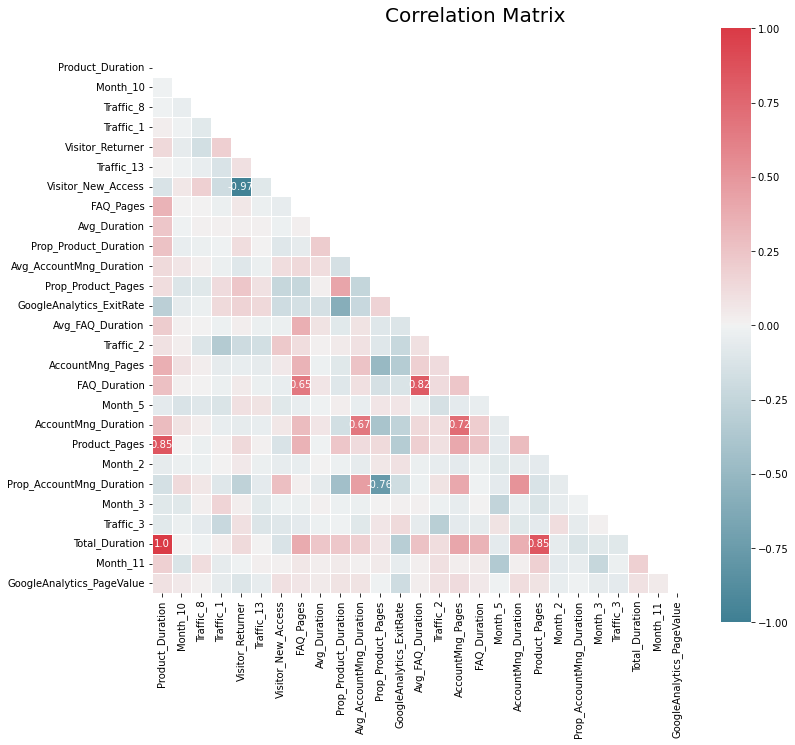

In [63]:
correlation(X_selected, 0.65, selected_features)

In [64]:
## drop correlated vars
X_selected.drop(columns=['Visitor_Returner','Product_Duration','Product_Pages','FAQ_Duration','AccountMng_Duration'], inplace=True)

In [123]:
X_test_selected = X_test_scaled.copy()
X_test_selected = X_test_selected[selected_features]
X_test_selected.drop(columns=['Visitor_Returner','Product_Duration','Product_Pages','AccountMng_Duration','FAQ_Duration'], inplace=True)

In [66]:
print(X_selected.shape)
print(X_test_selected.shape)

(7276, 22)
(2500, 22)


<hr>
<a class="anchor" id="train">
    
# 6. Model training
    
</a>

In [67]:
def get_results(model):
    """ This function builds a dataframe that can be exported with the results of the GridSearchCV.
    
    Atributes:
    - model: GridSearchCV object from which to extract the training and test results
    """
    
    mean_train = model.cv_results_['mean_train_score']
    mean_test = model.cv_results_['mean_test_score']
    params = model.cv_results_['params']
    
    return pd.DataFrame(data = zip(mean_train, mean_test, params), columns = ['Mean_Train', 'Mean_Test', 'Params'])

In [68]:
def f1_custom_scorer(y_true, y_pred, **kwargs):    
    """ Custom scorer to consider a specific threshold for event = 1 instead of the predefined 0.5 in GridSearch CV.
    Atributes:
    - y_true: array with observed y
    - y_pred: array with estimated probabilities for class 1
    """
    y_class = np.where(y_pred>=0.155,1,0)
    precision = metrics.precision_score(y_true,y_class)
    recall = metrics.recall_score(y_true,y_class)
    return (2 * precision * recall) / (precision + recall) 

fone_score = metrics.make_scorer(f1_custom_scorer, needs_proba=True)

In [69]:
# create a cross validation object
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [70]:
dt = DecisionTreeClassifier(random_state=10)
dt_params = {'max_depth': [2,3,4,5,6,7], 'min_samples_leaf': [80,90,100,110,120], 'criterion':['entropy','gini']}
dt_grid = GridSearchCV(dt, dt_params, scoring='roc_auc', return_train_score=True, n_jobs=-1, cv=skf).fit(X_selected,y_train)

In [71]:
dt_cv_results = get_results(dt_grid)
dt_cv_results.sort_values('Mean_Test', ascending=False)[:15]

,Mean_Train,Mean_Test,Params
21,0.939329,0.925835,"{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 90}"
20,0.940023,0.925166,"{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 80}"
26,0.940478,0.924649,"{'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 90}"
22,0.938335,0.924557,"{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 100}"
25,0.941624,0.923850,"{'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 80}"
23,0.937625,0.923711,"{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 110}"
27,0.939373,0.923576,"{'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 100}"
24,0.936740,0.923539,"{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 120}"
16,0.935769,0.922780,"{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 90}"
17,0.935245,0.922472,"{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 100}"


In [72]:
dt_select = dt_cv_results.iloc[21]

In [73]:
dt_select

Mean_Train                                                            0.939329
Mean_Test                                                             0.925835
Params        {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 90}
Name: 21, dtype: object

In [74]:
decisiontree = DecisionTreeClassifier(**dt_select['Params'], random_state=10).fit(X_selected,y_train)

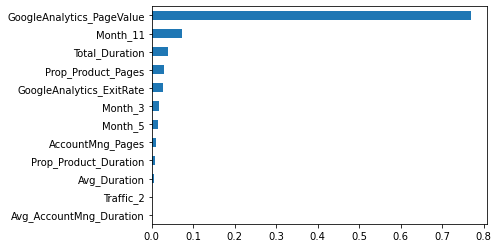

In [75]:
dt_featimp = pd.Series(decisiontree.feature_importances_, index=X_selected.columns)
dt_featimp = dt_featimp[dt_featimp>=0.001]
dt_featimp.sort_values().plot(kind='barh')
plt.show()

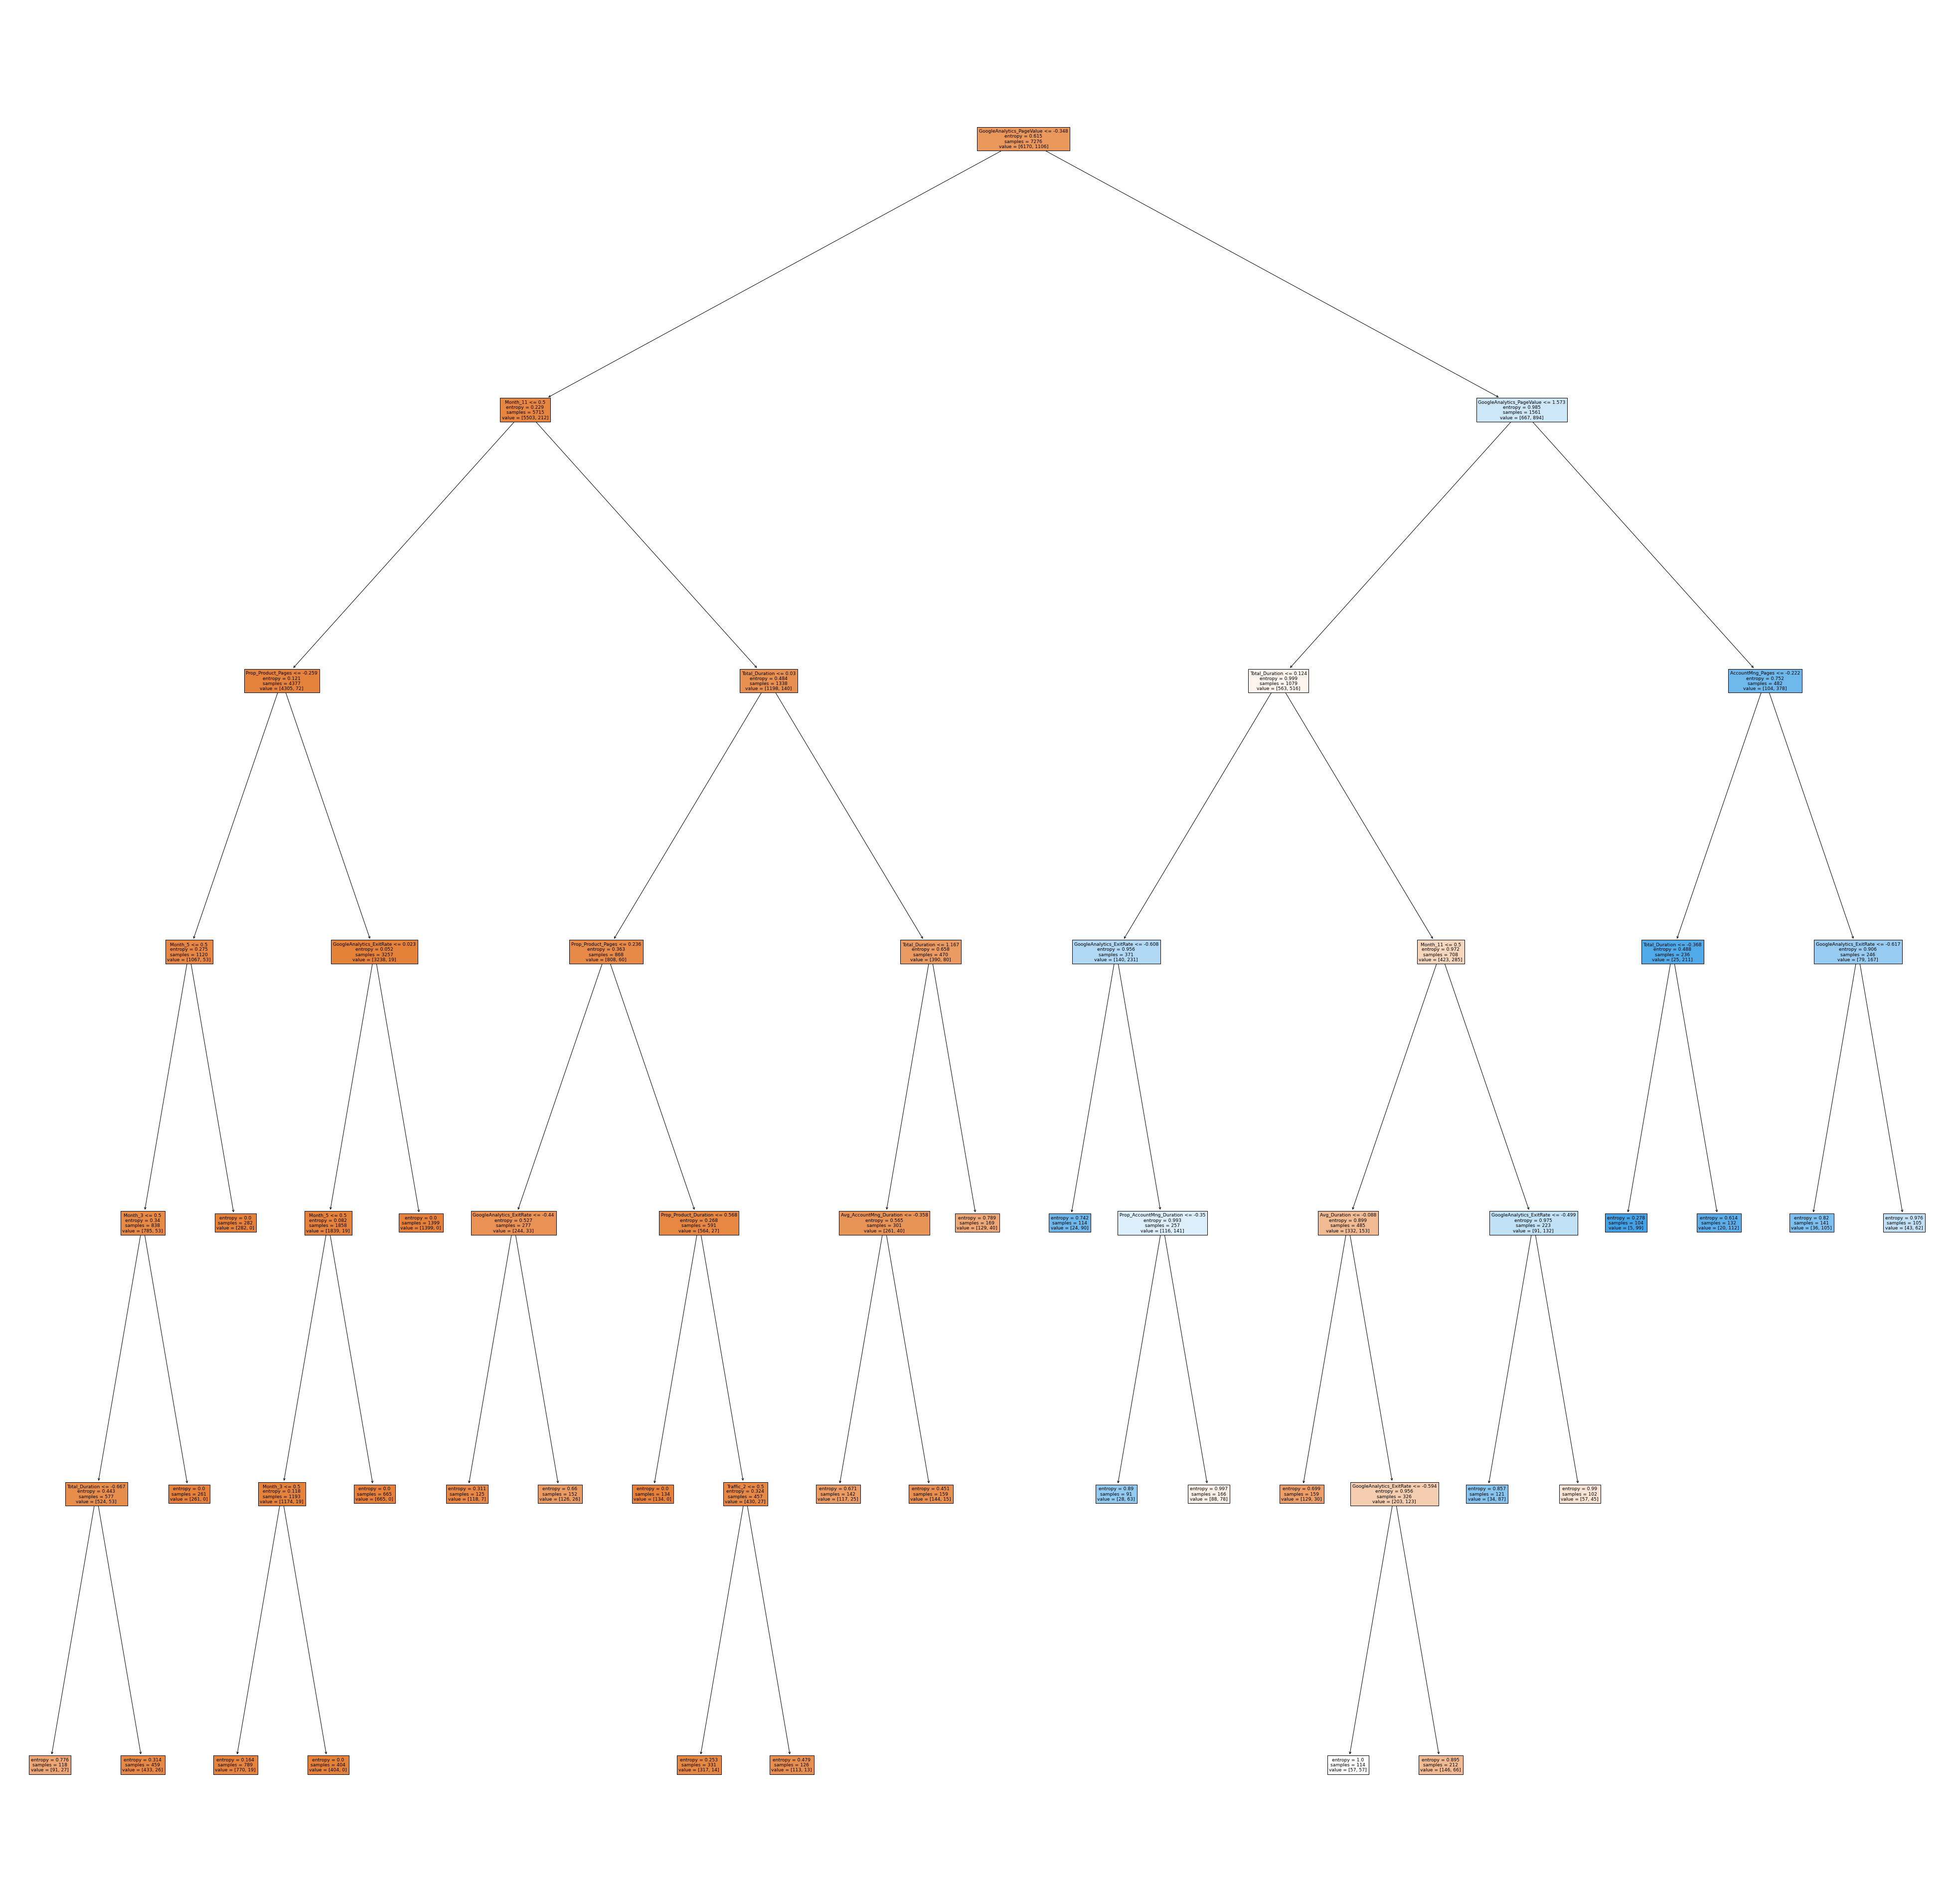

In [163]:
fig = plt.figure(figsize=(70,70))
tree.plot_tree(decisiontree, feature_names=X_selected.columns, filled=True)
plt.show()

Best Threshold=0.441176, F-Score=0.695


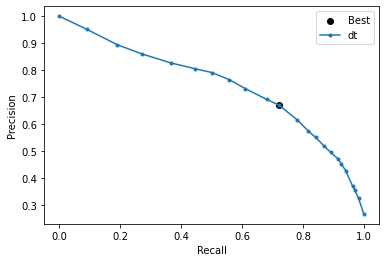

In [76]:
precision, recall, thresholds = metrics.precision_recall_curve(y_train, decisiontree.predict_proba(X_selected)[:,1])
# apply f1 score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.plot(recall, precision, marker='.', label='dt')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [77]:
# predict test sample

dt_thresh = thresholds[ix]
dt_class = pd.Series(np.where(decisiontree.predict_proba(X_test_selected)[:,1]>=dt_thresh,1,0), name='dt_prob', index=y_test.index)
dt_prob =  pd.Series(decisiontree.predict_proba(X_test_selected)[:,1], name='dt_prob', index=y_test.index)

model_metrics.loc['Decision Tree','Precision'] = round(metrics.precision_score(y_test, dt_class),3)
model_metrics.loc['Decision Tree','Recall'] = round(metrics.recall_score(y_test, dt_class),3)
model_metrics.loc['Decision Tree','F1 Score'] = round(metrics.f1_score(y_test, dt_class),3)
model_metrics.loc['Decision Tree','AUC'] = round(metrics.roc_auc_score(y_test, dt_prob),3)
model_metrics

,Precision,Recall,F1 Score,AUC
Decision Tree,0.63,0.706,0.666,0.928


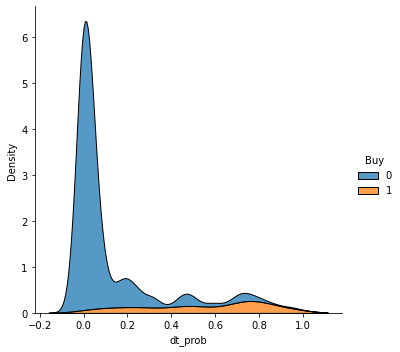

In [78]:
sns.displot(data=pd.concat([dt_prob,y_test], axis=1), x="dt_prob", hue="Buy", kind="kde", multiple="stack")
plt.show()

### 6.1) Random Forest

In [79]:
rf = RandomForestClassifier(random_state=10)
rf_params = {'max_depth': [5,6,7], 'min_samples_leaf': [5,10,15,20], 'n_estimators': [60,80,90,100]}
rf_grid = GridSearchCV(rf, rf_params, scoring='roc_auc', return_train_score=True, n_jobs=-1).fit(X_selected,y_train)

In [80]:
rf_cv_results = get_results(rf_grid)
rf_cv_results.sort_values('Mean_Test', ascending=False)[:20]

,Mean_Train,Mean_Test,Params
43,0.950997,0.928901,"{'max_depth': 7, 'min_samples_leaf': 15, 'n_estimators': 100}"
41,0.950828,0.928482,"{'max_depth': 7, 'min_samples_leaf': 15, 'n_estimators': 80}"
40,0.950560,0.928300,"{'max_depth': 7, 'min_samples_leaf': 15, 'n_estimators': 60}"
42,0.950819,0.928204,"{'max_depth': 7, 'min_samples_leaf': 15, 'n_estimators': 90}"
37,0.953067,0.927573,"{'max_depth': 7, 'min_samples_leaf': 10, 'n_estimators': 80}"
32,0.956492,0.927551,"{'max_depth': 7, 'min_samples_leaf': 5, 'n_estimators': 60}"
45,0.948401,0.927531,"{'max_depth': 7, 'min_samples_leaf': 20, 'n_estimators': 80}"
35,0.956808,0.927518,"{'max_depth': 7, 'min_samples_leaf': 5, 'n_estimators': 100}"
33,0.956721,0.927478,"{'max_depth': 7, 'min_samples_leaf': 5, 'n_estimators': 80}"
44,0.948402,0.927466,"{'max_depth': 7, 'min_samples_leaf': 20, 'n_estimators': 60}"


In [81]:
rf_select = rf_cv_results.iloc[46]

In [82]:
rf_select

Mean_Train                                                        0.948372
Mean_Test                                                         0.927199
Params        {'max_depth': 7, 'min_samples_leaf': 20, 'n_estimators': 90}
Name: 46, dtype: object

In [83]:
randomforest = RandomForestClassifier(**rf_select['Params'], random_state = 10).fit(X_selected, y_train)

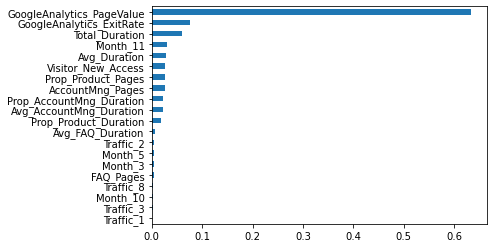

In [84]:
rf_featimp = pd.Series(randomforest.feature_importances_, index=X_selected.columns)
rf_featimp = rf_featimp[rf_featimp>=0.001]
rf_featimp.sort_values().plot(kind='barh')
plt.show()

Best Threshold=0.382993, F-Score=0.727


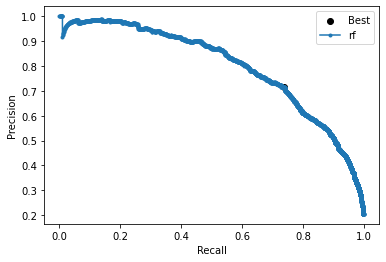

In [85]:
precision, recall, thresholds = metrics.precision_recall_curve(y_train, randomforest.predict_proba(X_selected)[:,1])
# apply f1 score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.plot(recall, precision, marker='.', label='rf')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [86]:
# predict test sample

rf_thresh = thresholds[ix]
rf_class = pd.Series(np.where(randomforest.predict_proba(X_test_selected)[:,1]>=rf_thresh,1,0), name='rf_prob', index=y_test.index)
rf_prob =  pd.Series(randomforest.predict_proba(X_test_selected)[:,1], name='rf_prob', index=y_test.index)

model_metrics.loc['Random Forest','Precision'] = round(metrics.precision_score(y_test, rf_class),3)
model_metrics.loc['Random Forest','Recall'] = round(metrics.recall_score(y_test, rf_class),3)
model_metrics.loc['Random Forest','F1 Score'] = round(metrics.f1_score(y_test, rf_class),3)
model_metrics.loc['Random Forest','AUC'] = round(metrics.roc_auc_score(y_test, rf_prob),3)
model_metrics

,Precision,Recall,F1 Score,AUC
Decision Tree,0.63,0.706,0.666,0.928
Random Forest,0.661,0.693,0.677,0.919


### 6.3) Gradient Boosting

In [87]:
gb = GradientBoostingClassifier(random_state=10)
gb_params = {'max_depth': [2,3,4], 'min_samples_leaf': [12,15,20], 'n_estimators': [70,75,80]}
gb_grid = GridSearchCV(gb, gb_params, scoring='roc_auc', return_train_score=True, n_jobs=-1).fit(X_selected,y_train)

In [88]:
gb_cv_results = get_results(gb_grid)
gb_cv_results.sort_values('Mean_Test', ascending=False)[:15]

,Mean_Train,Mean_Test,Params
21,0.961950,0.933433,"{'max_depth': 4, 'min_samples_leaf': 15, 'n_estimators': 70}"
24,0.962258,0.933398,"{'max_depth': 4, 'min_samples_leaf': 20, 'n_estimators': 70}"
9,0.951662,0.933316,"{'max_depth': 3, 'min_samples_leaf': 12, 'n_estimators': 70}"
10,0.952567,0.933287,"{'max_depth': 3, 'min_samples_leaf': 12, 'n_estimators': 75}"
22,0.963094,0.933224,"{'max_depth': 4, 'min_samples_leaf': 15, 'n_estimators': 75}"
11,0.953275,0.933180,"{'max_depth': 3, 'min_samples_leaf': 12, 'n_estimators': 80}"
25,0.963326,0.933132,"{'max_depth': 4, 'min_samples_leaf': 20, 'n_estimators': 75}"
16,0.952299,0.932987,"{'max_depth': 3, 'min_samples_leaf': 20, 'n_estimators': 75}"
26,0.964301,0.932894,"{'max_depth': 4, 'min_samples_leaf': 20, 'n_estimators': 80}"
17,0.953084,0.932884,"{'max_depth': 3, 'min_samples_leaf': 20, 'n_estimators': 80}"


In [89]:
gb_select = gb_cv_results.iloc[10]

In [90]:
gradientboost = GradientBoostingClassifier(**gb_select['Params'], random_state = 10).fit(X_selected, y_train)

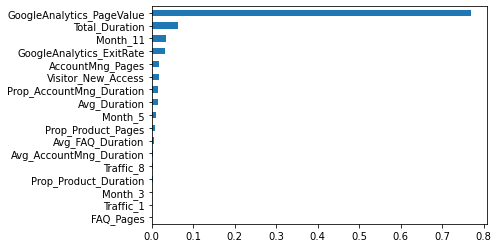

In [91]:
gb_featimp = pd.Series(gradientboost.feature_importances_, index=X_selected.columns)
gb_featimp = gb_featimp[gb_featimp>=0.001]
gb_featimp.sort_values().plot(kind='barh')
plt.show()

Best Threshold=0.368276, F-Score=0.730


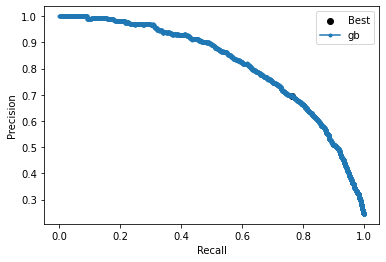

In [92]:
precision, recall, thresholds = metrics.precision_recall_curve(y_train, gradientboost.predict_proba(X_selected)[:,1])
# apply f1 score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.plot(recall, precision, marker='.', label='gb')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [93]:
# predict test sample

gb_thresh = thresholds[ix]
gb_class = pd.Series(np.where(gradientboost.predict_proba(X_test_selected)[:,1]>=gb_thresh,1,0), name='gb_prob', index=y_test.index)
gb_prob =  pd.Series(gradientboost.predict_proba(X_test_selected)[:,1], name='gb_prob', index=y_test.index)

model_metrics.loc['Gradient Boosting','Precision'] = round(metrics.precision_score(y_test, gb_class),3)
model_metrics.loc['Gradient Boosting','Recall'] = round(metrics.recall_score(y_test, gb_class),3)
model_metrics.loc['Gradient Boosting','F1 Score'] = round(metrics.f1_score(y_test, gb_class),3)
model_metrics.loc['Gradient Boosting','AUC'] = round(metrics.roc_auc_score(y_test, gb_prob),3)
model_metrics

,Precision,Recall,F1 Score,AUC
Decision Tree,0.63,0.706,0.666,0.928
Random Forest,0.661,0.693,0.677,0.919
Gradient Boosting,0.638,0.709,0.672,0.932


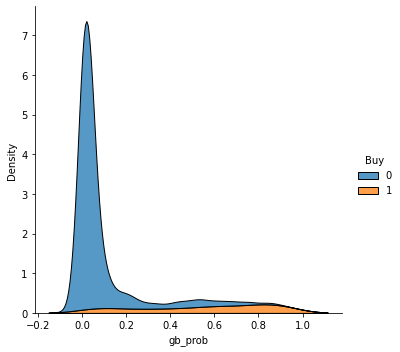

In [94]:
sns.displot(data=pd.concat([gb_prob,y_test], axis=1), x="gb_prob", hue="Buy", kind="kde", multiple="stack")
plt.show()

### 6.4) Logistic Regression

In [98]:
lr = LogisticRegression(max_iter=5000)
logreg_param = {'solver':['liblinear', 'lbfgs', 'saga'], 'C':[0.01,0.05,0.1]}
log_grid = GridSearchCV(logreg, logreg_param, scoring='roc_auc', return_train_score=True).fit(X_selected, y_train)

In [97]:
lr_cv_results = get_results(log_grid)
lr_cv_results.sort_values('Mean_Test', ascending=False)

,Mean_Train,Mean_Test,Params
0,0.909637,0.907050,"{'C': 0.01, 'solver': 'liblinear'}"
3,0.908655,0.905768,"{'C': 0.05, 'solver': 'liblinear'}"
2,0.907716,0.905557,"{'C': 0.01, 'solver': 'saga'}"
1,0.907708,0.905552,"{'C': 0.01, 'solver': 'lbfgs'}"
4,0.907288,0.904514,"{'C': 0.05, 'solver': 'lbfgs'}"
5,0.907296,0.904503,"{'C': 0.05, 'solver': 'saga'}"
6,0.907463,0.904461,"{'C': 0.1, 'solver': 'liblinear'}"
8,0.906515,0.903614,"{'C': 0.1, 'solver': 'saga'}"
7,0.906515,0.903614,"{'C': 0.1, 'solver': 'lbfgs'}"


In [99]:
logreg = LogisticRegression(solver='liblinear', C=0.01, max_iter=5000).fit(X_selected, y_train)

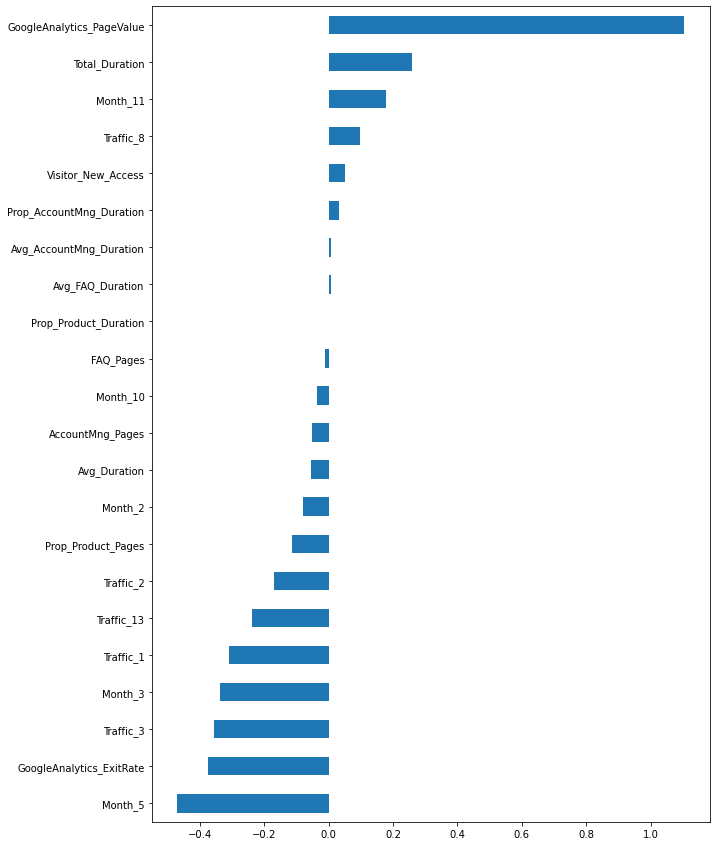

In [100]:
fig = plt.figure(figsize=(10,15))
log_featimp = pd.Series(logreg.coef_[0], index=X_selected.columns)
log_featimp = log_featimp[log_featimp!=0]
log_featimp.sort_values().plot(kind='barh')
plt.show()

Best Threshold=0.213903, F-Score=0.653


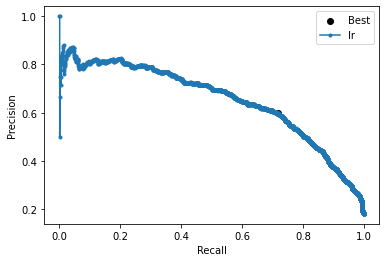

In [101]:
precision, recall, thresholds = metrics.precision_recall_curve(y_train, logreg.predict_proba(X_selected)[:,1])
# apply f1 score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.plot(recall, precision, marker='.', label='lr')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [102]:
# predict test sample

lr_thresh = thresholds[ix]
lr_class = pd.Series(np.where(logreg.predict_proba(X_test_selected)[:,1]>=lr_thresh,1,0), name='lr_prob', index=y_test.index)
lr_prob =  pd.Series(logreg.predict_proba(X_test_selected)[:,1], name='lr_prob', index=y_test.index)

model_metrics.loc['Logistic Regression','Precision'] = round(metrics.precision_score(y_test, lr_class),3)
model_metrics.loc['Logistic Regression','Recall'] = round(metrics.recall_score(y_test, lr_class),3)
model_metrics.loc['Logistic Regression','F1 Score'] = round(metrics.f1_score(y_test, lr_class),3)
model_metrics.loc['Logistic Regression','AUC'] = round(metrics.roc_auc_score(y_test, lr_prob),3)
model_metrics

,Precision,Recall,F1 Score,AUC
Decision Tree,0.63,0.706,0.666,0.928
Random Forest,0.661,0.693,0.677,0.919
Gradient Boosting,0.638,0.709,0.672,0.932
Logistic Regression,0.585,0.704,0.639,0.902


### 6.5) Support Vector Classifier

In [103]:
scv = SVC(probability=True,random_state=10)
svc_params = {'kernel': ['linear','rbf'], 'C':[0.1,0.5]}
svc_grid = GridSearchCV(scv, svc_params, scoring='roc_auc', return_train_score=True, n_jobs=-1).fit(X_selected, y_train)

In [104]:
scv_cv_results = get_results(svc_grid)
scv_cv_results.sort_values('Mean_Test', ascending=False)

,Mean_Train,Mean_Test,Params
2,0.903644,0.899617,"{'C': 0.5, 'kernel': 'linear'}"
0,0.903307,0.899510,"{'C': 0.1, 'kernel': 'linear'}"
1,0.907041,0.881534,"{'C': 0.1, 'kernel': 'rbf'}"
3,0.917313,0.881175,"{'C': 0.5, 'kernel': 'rbf'}"


In [108]:
supportvec = SVC(kernel='linear', C=0.05, probability=True,random_state=10).fit(X_selected, y_train)

Best Threshold=0.098002, F-Score=0.685


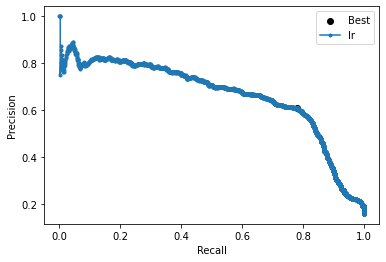

In [109]:
precision, recall, thresholds = metrics.precision_recall_curve(y_train, supportvec.predict_proba(X_selected)[:,1])
# apply f1 score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.plot(recall, precision, marker='.', label='lr')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [110]:
# predict test sample

sv_thresh = thresholds[ix]
sv_class = pd.Series(np.where(supportvec.predict_proba(X_test_selected)[:,1]>=lr_thresh,1,0), name='sv_prob', index=y_test.index)
sv_prob =  pd.Series(supportvec.predict_proba(X_test_selected)[:,1], name='sv_prob', index=y_test.index)

model_metrics.loc['Support Vector','Precision'] = round(metrics.precision_score(y_test, sv_class),3)
model_metrics.loc['Support Vector','Recall'] = round(metrics.recall_score(y_test, sv_class),3)
model_metrics.loc['Support Vector','F1 Score'] = round(metrics.f1_score(y_test, sv_class),3)
model_metrics.loc['Support Vector','AUC'] = round(metrics.roc_auc_score(y_test, sv_prob),3)
model_metrics

,Precision,Recall,F1 Score,AUC
Decision Tree,0.63,0.706,0.666,0.928
Random Forest,0.661,0.693,0.677,0.919
Gradient Boosting,0.638,0.709,0.672,0.932
Logistic Regression,0.585,0.704,0.639,0.902
Support Vector,0.675,0.562,0.613,0.874


### 6.6) Naive Bayes

In [114]:
nb = GaussianNB()
nb_params = {'var_smoothing':[0.001, 0.01, 0.1, 0.2]}
nb_grid = GridSearchCV(nb, nb_params, scoring=fone_score, return_train_score=True).fit(X_selected, y_train)

In [115]:
nb_cv_results = get_results(nb_grid)
nb_cv_results.sort_values('Mean_Test', ascending=False)

,Mean_Train,Mean_Test,Params
3,0.496686,0.487402,{'var_smoothing': 0.2}
2,0.476600,0.468552,{'var_smoothing': 0.1}
1,0.446546,0.442048,{'var_smoothing': 0.01}
0,0.423155,0.418279,{'var_smoothing': 0.001}


<hr>
<a class="anchor" id="imports">
    
# 8. Prediction
    
</a>

Considering the results table and basing the choice of performance AUC metric we will choose the GradientBoosting model to deployment. Before that let's inspect the quality of the model in a new sample. To do that lets ask kds for the report so we can assess the quality of the output.

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.604,0.957,0.780,250.0,191.0,59.0,38.8,250,76.4,250.0,191.0,250,59.0,10.0,49.227,64.433,2.794,46.433,4.923
1,2,0.251,0.603,0.446,250.0,109.0,141.0,38.8,138,43.6,500.0,300.0,388,200.0,20.0,77.320,100.000,9.470,67.850,3.866
2,3,0.091,0.249,0.155,250.0,50.0,200.0,38.8,0,20.0,750.0,350.0,388,400.0,30.0,90.206,100.000,18.939,71.267,3.007
3,4,0.040,0.091,0.062,250.0,20.0,230.0,38.8,0,8.0,1000.0,370.0,388,630.0,40.0,95.361,100.000,29.830,65.531,2.384
4,5,0.027,0.040,0.033,250.0,12.0,238.0,38.8,0,4.8,1250.0,382.0,388,868.0,50.0,98.454,100.000,41.098,57.356,1.969
5,6,0.020,0.027,0.023,250.0,3.0,247.0,38.8,0,1.2,1500.0,385.0,388,1115.0,60.0,99.227,100.000,52.794,46.433,1.654
6,7,0.014,0.020,0.016,250.0,3.0,247.0,38.8,0,1.2,1750.0,388.0,388,1362.0,70.0,100.000,100.000,64.489,35.511,1.429
7,8,0.010,0.014,0.012,250.0,0.0,250.0,38.8,0,0.0,2000.0,388.0,388,1612.0,80.0,100.000,100.000,76.326,23.674,1.250
8,9,0.007,0.010,0.009,250.0,0.0,250.0,38.8,0,0.0,2250.0,388.0,388,1862.0,90.0,100.000,100.000,88.163,11.837,1.111
9,10,0.005,0.007,0.006,250.0,0.0,250.0,38.8,0,0.0,2500.0,388.0,388,2112.0,100.0,100.000,100.000,100.000,0.000,1.000


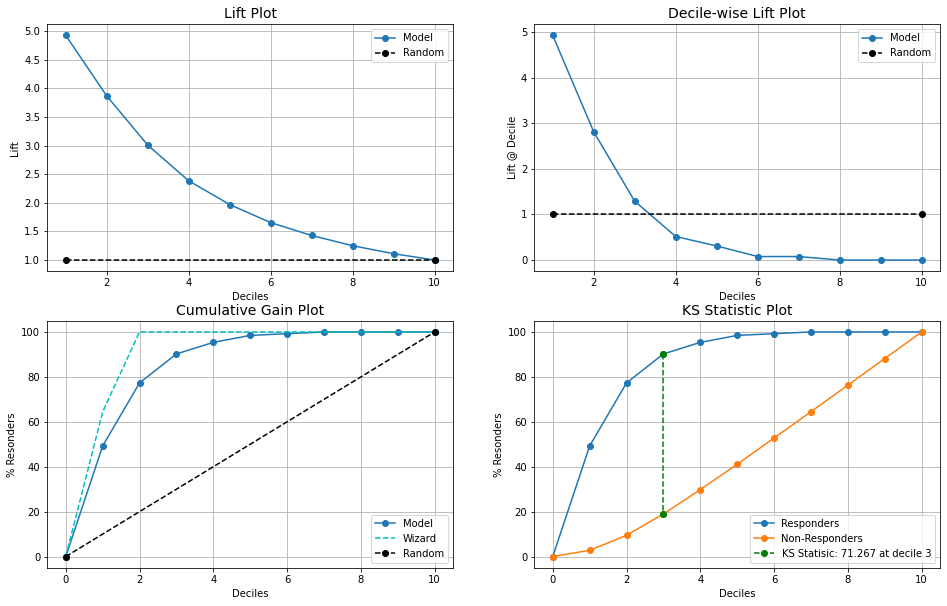

In [127]:
kds_metrics.report(y_test,gb_prob)

Analysing the Decile-wise Lift Plot from kds report we can conclude that the model presents a really good performance, ordering the clients in a proper way regarding conversion propensity - the top decile presents a lift of 5, this means that the conversion on this decile (76.4%) is 5 times higher than the average conversion of the sample.
Analysing Cumulative Gain Plot we can see that the model curve is pretty close to the perfer model identifying close to 80% of the true responders by the second decile. This means that if we would use the 2 top deciles to identify the leads for a campaing we would contact 500 clients and expect a 43% conversion rate (~4 lift) and capture 80% of the true conversions.